<a href="https://colab.research.google.com/github/vicvarar/TFMG5/blob/main/VikLabTFM5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
comprasdf=pd.read_csv('https://raw.githubusercontent.com/megatr0ll/TFM/main/steam_data/game_purchase.csv',
            sep=';', names=['User_ID', 'Game_ID', 'Purchase'])

In [3]:
horasdf=pd.read_csv('https://raw.githubusercontent.com/megatr0ll/TFM/main/steam_data/game_play.csv',
            sep=';', names=['User_ID', 'Game_ID', 'Hours'])

In [4]:
itemdf=pd.read_csv('https://raw.githubusercontent.com/megatr0ll/TFM/main/steam_data/item_info.csv',
            sep=';', names=['Game_ID', 'Game Name'])

In [5]:
userdf=pd.read_csv('https://raw.githubusercontent.com/megatr0ll/TFM/main/steam_data/user_info.csv',
            sep=';', names=['New_ID', 'Real_ID'])

In [6]:
userdf.head()


,New_ID,Real_ID
0,New_ID,Real_ID
1,1,151603712
2,2,187131847
3,3,59945701
4,4,53875128


In [7]:
horasdf.head()

,User_ID,Game_ID,Hours
0,User_ID,Game_ID,Hours
1,1,1,273.0
2,1,2,87.0
3,1,3,14.9
4,1,4,12.1


In [8]:
comprasdf.head()

,User_ID,Game_ID,Purchase
0,User_ID,Game_ID,Purchase
1,1,1,1.0
2,1,2,1.0
3,1,3,1.0
4,1,4,1.0


In [9]:
itemdf.head()

,Game_ID,Game Name
0,Game_ID,Game Name
1,1,The Elder Scrolls V Skyrim
2,2,Fallout 4
3,3,Spore
4,4,Fallout New Vegas


In [10]:
# standard library imports
import csv
import datetime as dt
import json
import os
import statistics
import time

# third-party imports
import numpy as np
import pandas as pd
import requests

# customisations - ensure tables sh

In [11]:
def get_request(url, parameters=None):
    """Return json-formatted response of a get request using optional parameters.
    
    Parameters
    ----------
    url : string
    parameters : {'parameter': 'value'}
        parameters to pass as part of get request
    
    Returns
    -------
    json_data
        json-formatted response (dict-like)
    """
    try:
        response = requests.get(url=url, params=parameters)
    except SSLError as s:
        print('SSL Error:', s)
        
        for i in range(5, 0, -1):
            print('\rWaiting... ({})'.format(i), end='')
            time.sleep(1)
        print('\rRetrying.' + ' '*10)
        
        # recusively try again
        return get_request(url, parameters)
    
    if response:
        return response.json()
    else:
        # response is none usually means too many requests. Wait and try again 
        print('No response, waiting 10 seconds...')
        time.sleep(10)
        print('Retrying.')
        return get_request(url, parameters)

In [22]:
url = "https://steamspy.com/api.php"
parameters = {"request": "all"}

# request 'all' from steam spy and parse into dataframe
json_data = get_request(url, parameters=parameters)
steam_spy_all = pd.DataFrame.from_dict(json_data, orient='index')

steam_spy_all.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu
570,570,Dota 2,Valve,Valve,,1434815,284839,0,"100,000,000 .. 200,000,000",38155,1565,1079,927,0,0,0,551497
730,730,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,,5609349,748640,0,"50,000,000 .. 100,000,000",30492,784,7775,260,0,0,0,755785
578080,578080,PUBG: BATTLEGROUNDS,"KRAFTON, Inc.","KRAFTON, Inc.",,1123879,882085,0,"50,000,000 .. 100,000,000",22834,830,8275,270,0,0,0,423930
1063730,1063730,New World,Amazon Games,Amazon Games,,152782,72351,0,"50,000,000 .. 100,000,000",6716,382,3070,240,3999,3999,0,28117
440,440,Team Fortress 2,Valve,Valve,,805121,54852,0,"50,000,000 .. 100,000,000",7588,1301,379,242,0,0,0,74258


In [23]:
steam_spy_all.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 570 to 1178830
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   appid            1000 non-null   int64 
 1   name             1000 non-null   object
 2   developer        1000 non-null   object
 3   publisher        1000 non-null   object
 4   score_rank       1000 non-null   object
 5   positive         1000 non-null   int64 
 6   negative         1000 non-null   int64 
 7   userscore        1000 non-null   int64 
 8   owners           1000 non-null   object
 9   average_forever  1000 non-null   int64 
 10  average_2weeks   1000 non-null   int64 
 11  median_forever   1000 non-null   int64 
 12  median_2weeks    1000 non-null   int64 
 13  price            1000 non-null   object
 14  initialprice     1000 non-null   object
 15  discount         1000 non-null   object
 16  ccu              1000 non-null   int64 
dtypes: int64(9), object(8)
memory usa

In [24]:
steam_spy_all.describe()

,appid,positive,negative,userscore,average_forever,average_2weeks,median_forever,median_2weeks,ccu
count,1.000000e+03,1.000000e+03,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.231249e+05,5.775569e+04,8537.238000,0.0,2025.854000,212.276000,641.491000,224.518000,5825.355000
std,3.805359e+05,2.090611e+05,39932.577013,0.0,3863.737929,528.425419,1412.820257,602.053842,38006.645772
min,1.000000e+01,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.061450e+05,9.297250e+03,1310.000000,0.0,376.500000,0.000000,132.750000,0.000000,72.000000
50%,3.052750e+05,2.129000e+04,2767.000000,0.0,888.500000,13.000000,293.000000,13.500000,377.000000
75%,5.829825e+05,4.880475e+04,5968.000000,0.0,1943.000000,218.500000,657.250000,197.750000,1698.250000
max,1.887990e+06,5.609349e+06,882085.000000,0.0,44354.000000,6657.000000,23779.000000,6736.000000,755785.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f16df4b8b10>,
      dtype=object)

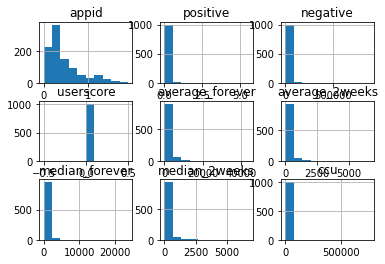

In [25]:
steam_spy_all.hist()